In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import scipy.stats

import scipy as sp;
from numpy.random import multinomial as multi;
from numpy.random import laplace as Lap;

In [2]:
def chi2(n):
    a = 2*n[0] + n[1]; b = 2*n[3] + n[4]
    R = 2*(n[0]+n[1]+n[2]); S = 2*(n[3]+n[4]+n[5])
    N = R+S
    
    return (N*((a*S-b*R)**2))/(R*S*(a+b)*(N-a-b))

In [3]:
# pseudo_SHD

def pseudo_SHD(n):
    a = 2*n[0] + n[1]; b = 2*n[3] + n[4]
    c = n[1] + 2*n[2]; d = n[4] + 2*n[5]
    
    return (math.fabs(a-b)+math.fabs(c-d))/4

In [4]:
# simple Permute-and-Flip (Algorithm 2)

def PnF(score, m, K,epsilon):
    y = np.zeros(K)
    z = np.zeros(m)
    for i in range(m):
        z[i] = score[i]
    
    for j in range(K):
        q = max(z[0:m-j])
        l = np.zeros(m-j)
        for i in range(m-j):
            l[i] = i
        random.shuffle(l)
        
        for i in range(m-j):
            p = math.exp((epsilon*(z[int(l[i])]-q))/(2*K))
            if(random.random()<=p):
                y[j] = int(l[i])
                for t in range(int(y[j]),m-j-1):
                    z[t] = z[t+1]
                break
    
    for j in range(1,K):
        yy = np.zeros(j)
        for i in range(j):
            yy[i] = y[i]
        yy.sort()
        for i in range(j):
            if y[j] >= yy[i]:
                y[j] += 1
    return y

In [5]:
# (Efficient) Joint Permute-and-Flip

def JointPnF(score, m, K, epsilon):
    S = np.zeros(K)
    SS = np.zeros(K)
    w = np.zeros(m)
    
    si = np.argsort(-score)
    c = np.zeros(m)
    for i in range(m):
        c[si[i]] = i
    ss = sorted(score, reverse=True)
    for i in range(K-1,m):
        if i == K-1:
            C = 1
        else:
            C = (C/(i-K+1)) * i
        r = np.random.rand()
        if r**(1/C)==1:
            D = C
            p = 16
            while(1):
                D /= 10
                p += 1
                if r**(1/D) != 1:
                    l = (1 - r**(1/D))*(10**16)
                    break
            x = -(2/epsilon)*(math.log(l) + (-1*p)*math.log(10))
        else:
            x = -(2/epsilon)*math.log(1-r**(1/C))
        w[i] = ss[i] + x
    SS[K-1] = np.argmax(w[K-1:m]) + K-1
    SS[0:K-1] = np.random.choice(int(SS[K-1]), size=K-1, replace=False)
    
    for i in range(K):
        S[i] = c[int(SS[i])]
    
    return S

In [6]:
def generate_data(N, M):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    n = np.zeros((M,6))
    
    for i in range(M-10):
        n[i][0] = np.random.binomial(int(N/2),1/3)
        n[i][1] = np.random.binomial((int(N/2)-n[i][0]), 1/2)
        n[i][2] = int(N/2)-n[i][0]-n[i][1]
        n[i][3] = np.random.binomial(int(N/2),1/3)
        n[i][4] = np.random.binomial((int(N/2)-n[i][3]), 1/2)
        n[i][5] = int(N/2)-n[i][3]-n[i][4]
    
    for i in range(M-10,M):
        n[i][0] = np.random.binomial(int(N/2),1/7)
        n[i][1] = np.random.binomial((int(N/2)-n[i][0]), 1/4)
        n[i][2] = int(N/2)-n[i][0]-n[i][1]
        n[i][3] = np.random.binomial(int(N/2),1/2)
        n[i][4] = np.random.binomial((int(N/2)-n[i][3]), 1/1.5)
        n[i][5] = int(N/2)-n[i][3]-n[i][4]
    
    return n

In [7]:
def evaluation(K, N, M):
    RankError = np.zeros((7,2))
    b = np.zeros(M)
    c = np.zeros(M)
    stats = np.zeros(M)
    
    re = np.zeros((7,2))
    
    for j in range(50):
        n = generate_data(N,M)
        
        for i in range(M):
            stats[i] = chi2(n[i])
            
        EXACT = np.zeros(M)
        PSEUDO = np.zeros(M)
        
        x = np.argsort(-stats)
        
        cc = 19.5
        
        for i in range(M):
            a = int(x[i])
            r0 = int(n[a][0]); r1 = int(n[a][1]); r2 = int(n[a][2])
            s0 = int(n[a][3]); s1 = int(n[a][4]); s2 = int(n[a][5])
            k = [r0,r1,r2,s0,s1,s2]
            PSEUDO[i] = pseudo_SHD(k)
    
        for i in range(7):
            pseudo_shd = PSEUDO
            shd = EXACT
            if K == 7:
                PnF_result = PnF(pseudo_shd,M,K,i+3.7)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+3.7)
            if K == 5:
                PnF_result = PnF(pseudo_shd,M,K,i+2.5)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+2.5)
            if K == 3:
                PnF_result = PnF(pseudo_shd,M,K,i+1.5)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.5)
            if K == 1:
                PnF_result = PnF(pseudo_shd,M,K,i+1.0)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.0)
            re[i][0] += sum(PnF_result)-(K-1)*K/2
            re[i][1] += sum(JointPnF_result)-(K-1)*K/2
                
    RankError = re/(50*K)
    return RankError

[[5.27344e+02 4.11552e+02]
 [5.99000e+01 8.12000e-01]
 [1.94000e+00 4.20000e-01]
 [3.56000e-01 2.80000e-01]
 [2.36000e-01 2.60000e-01]
 [2.36000e-01 2.60000e-01]
 [1.48000e-01 2.00000e-01]]
[[4.83924e+02 2.91208e+02]
 [3.01520e+01 5.44000e-01]
 [3.16000e-01 4.24000e-01]
 [4.08000e-01 4.24000e-01]
 [2.28000e-01 3.12000e-01]
 [2.48000e-01 2.96000e-01]
 [1.84000e-01 2.40000e-01]]
[[4.82068e+02 3.24224e+02]
 [4.89320e+01 5.60000e-01]
 [1.65600e+00 4.48000e-01]
 [4.16000e-01 3.20000e-01]
 [2.80000e-01 4.08000e-01]
 [2.76000e-01 2.64000e-01]
 [2.48000e-01 2.88000e-01]]
[[5.02908e+02 3.72092e+02]
 [3.94200e+01 7.60000e-01]
 [2.15560e+01 4.52000e-01]
 [4.20000e-01 4.08000e-01]
 [3.20000e-01 3.72000e-01]
 [3.00000e-01 3.08000e-01]
 [2.68000e-01 3.32000e-01]]
[[5.76024e+02 3.91968e+02]
 [9.32720e+01 7.04000e-01]
 [4.43600e+00 6.76000e-01]
 [2.96000e-01 4.08000e-01]
 [3.28000e-01 3.96000e-01]
 [2.36000e-01 3.20000e-01]
 [1.80000e-01 1.88000e-01]]
[[5.144536e+02 3.582088e+02]
 [5.433520e+01 6.7600

Text(0, 0.5, 'rank error')

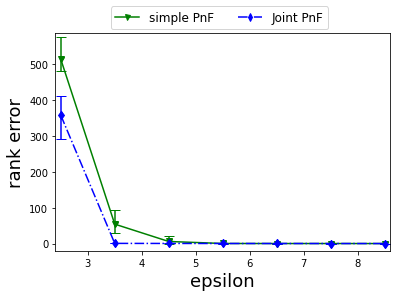

In [8]:
# n = 150, M = 5000
# K = 5

RE = np.zeros((7,2))
max_RE = np.zeros((7,2)); min_RE = np.ones((7,2))*5000
sum_RE = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    RE = evaluation(5,150,5000)
    for i in range(7):
        epsilon[i] = i+2.5
        for k in range(2):
            if RE[i][k] > max_RE[i][k]:
                max_RE[i][k] = RE[i][k]
            if RE[i][k] < min_RE[i][k]:
                min_RE[i][k] = RE[i][k]
            sum_RE[i][k] += RE[i][k]
    print(RE)
RE = sum_RE/5

for k in range(2):
    y_err[0,:,k] = RE[:,k] - min_RE[:,k]
    y_err[1,:,k] = max_RE[:,k] - RE[:,k]

print(RE)
fig = plt.figure()
plt.ylim(-20, max(max(max_RE[:,0]),max(max_RE[:,1]))+10)
plt.xlim(2.4, 8.6)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)